Copenhagen Business School

MSc in Business Administration and Data Science

Machine Learning & Deep Learning

Mandatory Assignment 1




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the datasets
listings = pd.read_csv("/content/drive/MyDrive/CBS/Machine Learning and Deep Learning/Assignment 1/listings.csv")
reviews = pd.read_csv("/content/drive/MyDrive/CBS/Machine Learning and Deep Learning/Assignment 1/reviews.csv")

In [ ]:
listings.head() # display the first 5 rows if the listings dataset

In [ ]:
reviews.head() # display the first 5 rows if the reviews dataset

QUESTION 1

1.1 Exploratory Data Analysis (EDA)
Perform EDA on the given data set that covers the following items.
1. Write a Python code to count the total number of rows and columns in the given data. Your
code must also find if there are missing values in any of the columns or rows.

In [ ]:
# We decided to make a summarize function
def summarize_data(df):
    # Print total number of rows and columns in the DataFrame
    print(f"Total rows: {df.shape[0]}\nTotal columns: {df.shape[1]}")

    # Calculate the number of missing values in each column
    missing_values = df.isnull().sum()
    missing_columns = missing_values[missing_values > 0]

    # Check if there are columns with missing values and print details
    if not missing_columns.empty:
        print("Columns with missing values:")
        for column, missing_count in missing_columns.items():
            print(f"-{column}: {missing_count}")
    else:
        # No missing values in any column
        print("No missing values found.")

    # Count total rows that have any missing values
    rows_with_missing = df.isnull().any(axis=1).sum()  # axis=1 checks across columns for each row
    if rows_with_missing > 0:
        print(f"Total rows with any missing values: {rows_with_missing}")
    else:
        # No missing values in any row
        print("No missing values found in any row.")
    print("\n")

    # Calculate and print the percentage of missing values for columns with missing data
    missing_values_percentage = (df.isnull().sum() / len(df)) * 100
    columns_with_missing_values = missing_values_percentage[missing_values_percentage > 0]
    sorted_columns_with_missing_values = columns_with_missing_values.sort_values(ascending=False)
    print("Columns with missing values by percentage:")
    print(sorted_columns_with_missing_values)


In [ ]:
summarize_data(listings)

In [ ]:
summarize_data(reviews)

2. Write another Python code to visualize the data. Hints: You might look into histograms, boxplots,
scatterplots few to name.

In [ ]:
# Price distribution by Neighborhood
listings2 = listings
listings2.dropna(subset=['price'], inplace=True)
sns.boxplot(x='neighbourhood', y='price', data=listings)
plt.xticks(rotation=90)
plt.title('Price Distribution by Neighborhood')
plt.show()


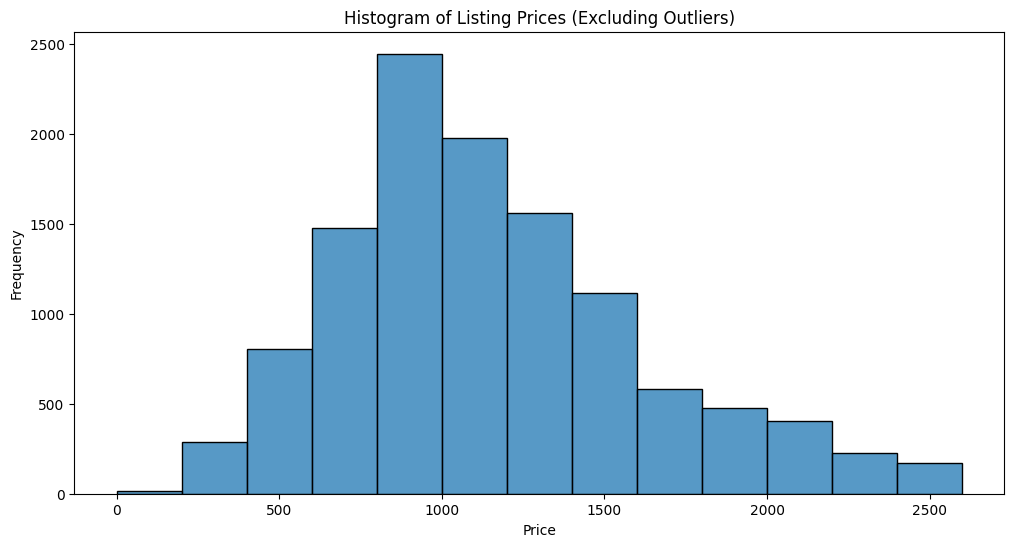

In [ ]:
##For the listings dataset
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# Remove outliers from 'price'
Q1 = listings['price'].quantile(0.25)
Q3 = listings['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to exclude outliers
filtered_listings = listings[(listings['price'] >= lower_bound) & (listings['price'] <= upper_bound)]

# Histogram for 'price' without outliers, with bins of 200
plt.figure(figsize=(12, 6))
sns.histplot(filtered_listings['price'], bins=range(0, int(max(filtered_listings['price']) + 200), 200), kde=False)
plt.title('Histogram of Listing Prices (Excluding Outliers)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

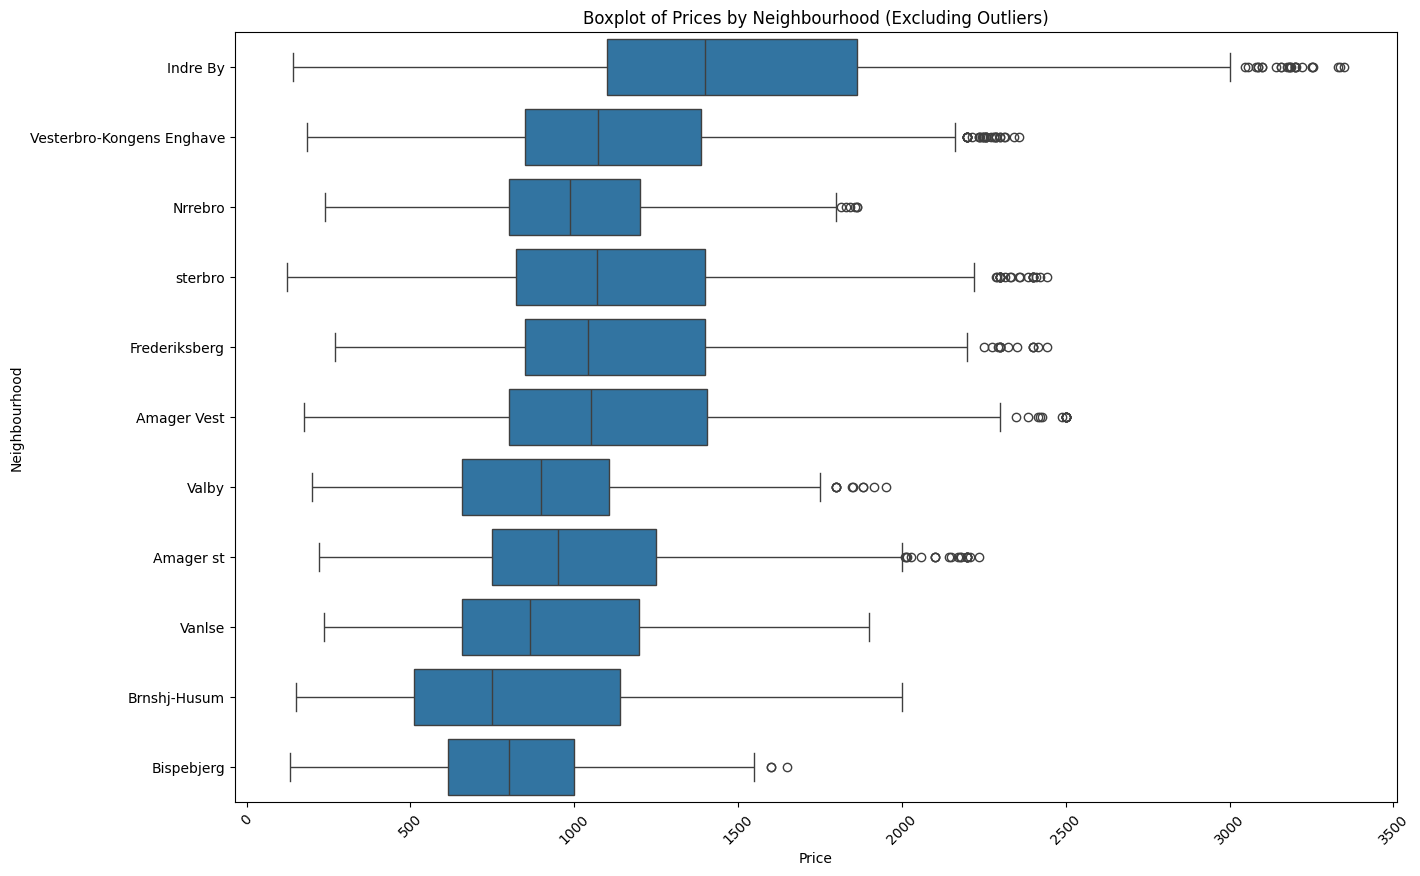

In [ ]:
# Calculate the IQR for 'price' in each neighborhood
Q1 = listings.groupby('neighbourhood')['price'].quantile(0.25)
Q3 = listings.groupby('neighbourhood')['price'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers in each neighborhood
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Apply a filter to remove outliers from each neighborhood
# This creates a mask for each listing, indicating whether it's an outlier in its neighborhood
is_not_outlier = listings.apply(lambda x: (x['price'] >= lower_bound[x['neighbourhood']]) &
                                             (x['price'] <= upper_bound[x['neighbourhood']]), axis=1)

# Filter the listings DataFrame to exclude outliers
filtered_listings = listings[is_not_outlier]

# Now, create the boxplot for 'price' by 'neighbourhood' without outliers
plt.figure(figsize=(15, 10))  # Adjust figure size as needed
sns.boxplot(x='price', y='neighbourhood', data=filtered_listings)
plt.title('Boxplot of Prices by Neighbourhood (Excluding Outliers)')
plt.xlabel('Price')
plt.ylabel('Neighbourhood')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

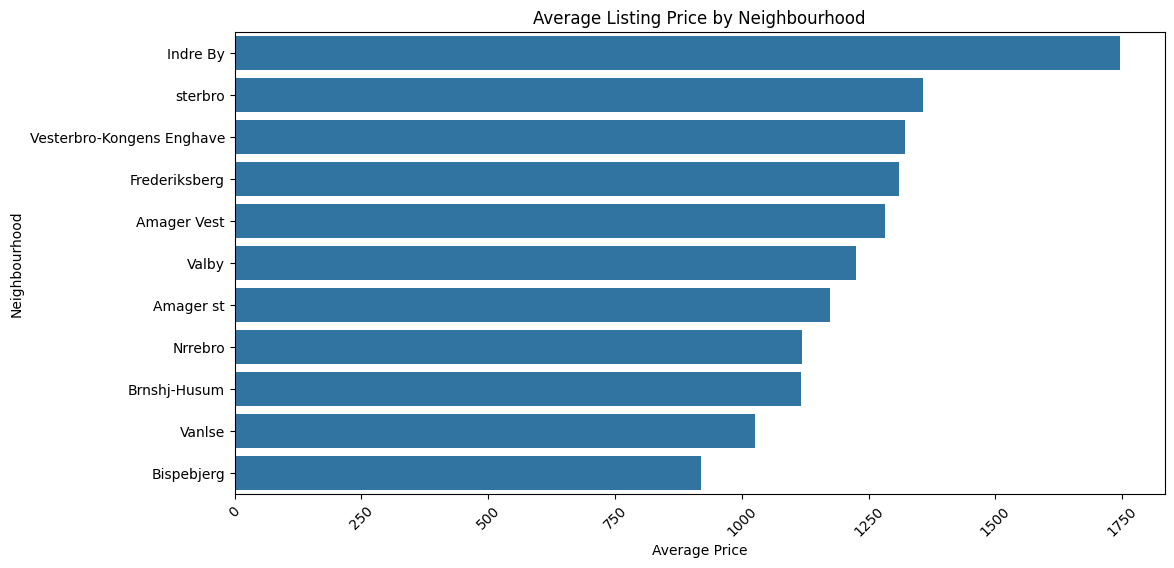

In [ ]:
# Bar plot for 'price' by 'neighbourhood'

neighbourhood_prices = listings.groupby('neighbourhood')['price'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='price', y='neighbourhood', data=neighbourhood_prices.sort_values('price', ascending=False))
plt.title('Average Listing Price by Neighbourhood')
plt.xlabel('Average Price')
plt.ylabel('Neighbourhood')
plt.xticks(rotation=45)  # Rotate labels to improve readability if necessary
plt.show()

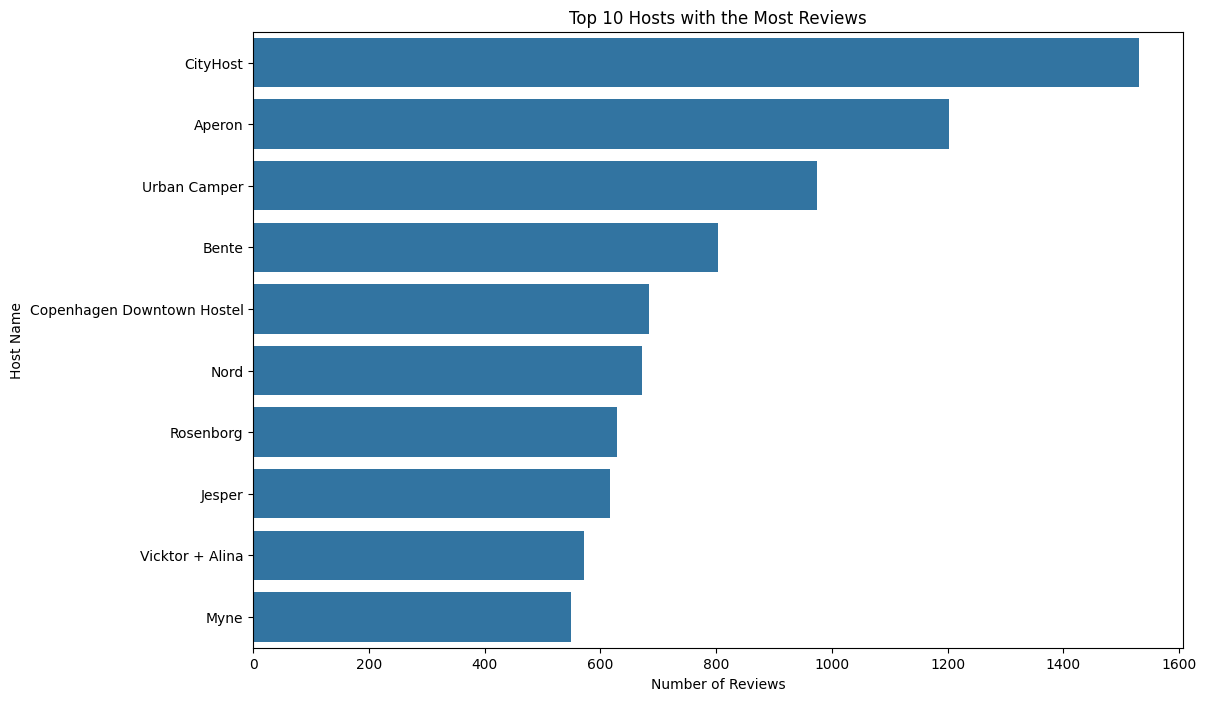

In [ ]:
review_counts = reviews['listing_id'].value_counts().reset_index()
review_counts.columns = ['listing_id', 'review_count']

# Select the top 10 'listing_id's with the most reviews
top_review_counts = review_counts.head(10)

# Join with the 'listings' DataFrame to get host names
# Ensure that the 'listing_id' in 'reviews' and the relevant column in 'listings' are of the same data type
top_reviews_with_hosts = pd.merge(top_review_counts, listings[['id', 'host_name']], left_on='listing_id', right_on='id', how='left')

# Create a bar plot for the top 10 'listing_id's with host names
plt.figure(figsize=(12, 8))
sns.barplot(x='review_count', y='host_name', data=top_reviews_with_hosts, orient='h')
plt.title('Top 10 Hosts with the Most Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Host Name')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Assuming 'listings' DataFrame is already loaded with the necessary columns

# Focus on 'latitude', 'longitude', 'price', and 'number_of_reviews' for clustering
data = listings[['latitude', 'longitude', 'price', 'number_of_reviews']].dropna()

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)  # Specifying n_init explicitly to avoid the warning
clusters = kmeans.fit_predict(data_scaled)

# Since we've dropped rows with NaN values, directly add the cluster labels to 'data' DataFrame
data['cluster'] = clusters

# Now, if you want to visualize the clusters or analyze them, use 'data' instead of the original 'listings'
plt.figure(figsize=(10, 6))
plt.scatter(data['longitude'], data['latitude'], c=data['cluster'], cmap='viridis', marker='o', s=20, alpha=0.5)
plt.title('K-Means Clustering of Airbnb Listings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()

NameError: name 'listings' is not defined

1.2 Clustering
Choose one of the clustering algorithms that were covered during the lectures. Then choose the desired columns from the data that you think are suitable for clustering. Explain the results, and you
are free to use graphs/plots and any other sort of visualization.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


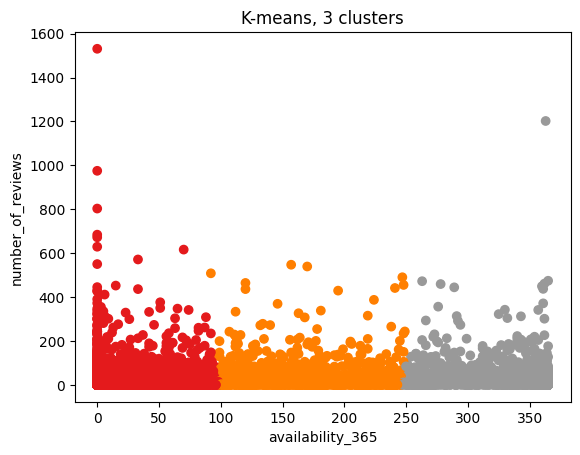

In [ ]:
#Clustering with Kmeans for 2 columns
X = listings[["availability_365", "number_of_reviews"]]
km = KMeans(n_clusters = 3, random_state = 1)
km.fit(X)

km.labels_

# number of clusters
nClusters = 3

#ploting cluster
plt.scatter(listings["availability_365"], listings["number_of_reviews"], c=km.labels_, cmap='Set1')
plt.title("K-means, {} clusters".format(nClusters))
plt.xlabel("availability_365")
plt.ylabel("number_of_reviews")
plt.show()



Above, we can see that it's evident clustering doesn't work very well when we don't have defined differences in the data.

The variable "availability_365" seems to spread across all clusters without showing a clear pattern that separates the clusters. Similarly, the "number_of_reviews" also doesn't seem to have a distinct pattern that differentiates the clusters effectively.

QUESTION 2
Principal Component Analysis (PCA)





1. Apply PCA on Olivetti faces dataset, while preserving 99% of the variance. Then compute the
reconstruction error for each image.





In [ ]:
# import the packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from skimage import transform, util


In [ ]:
#Import data
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
# Perform PCA
pca = PCA(0.99) #retain 99% of usefull features and create new dimensions (calculate new columns)
df_pca = pca.fit_transform(faces.data) #We have gone from 4096 columns to 260

In [ ]:
# Review difference before and after PCA
original = len(df_pca[0])
pca_imp = len((faces.data[0]))

f"Implementing PCA while retaining 99% of the original variance, the number of components have gone from {original} to {pca_imp}"
#This function takes the PCA-transformed data (df_pca) and reconstructs it back to its original number of dimensions (features) before the reduction.

'Implementing PCA while retaining 99% of the original variance, the number of components have gone from 260 to 4096'

In [ ]:
# Calculate and view reonstruction error

reconstructed_images = pca.inverse_transform(df_pca).reshape(faces.images.shape)
average_reconstruction_error = mean_squared_error(faces.data, reconstructed_images.reshape(faces.data.shape))
print("Average Reconstruction Error:", average_reconstruction_error)
# We recieve the value Average Reconstruction Error: 0.00019257102
# Since we retained 99% of the pictures variance a low value is to be expected

Average Reconstruction Error: 0.00019257102


2. Next, take some of the images you built using the PCA (previous step) and modify/add some
noise to some of the images using techniques such as rotate, flip, and darken (use libraries such
as scikit-image [1]) and look at their reconstruction error. You should also notice how much
larger the reconstruction error is.

In [ ]:
# Select an image to modify
original_image_index = 0

# Reshape the selected PCA-reconstructed image to its original 2D shape (64x64 pixels) for display
reconstructed_image = reconstructed_images[original_image_index].reshape(64, 64)

In [ ]:
#Add rotation and random noise to reconstructed PCA picture
modified_image = transform.rotate(reconstructed_image, angle=45)  # Rotate the image
modified_image = modified_image * 0.5  # Darken picture
modified_image = util.random_noise(modified_image)  # Add random noise

In [ ]:
# Flatten the modified image to a 1D array for PCA transformation
modified_image_flattened = modified_image.flatten()

# Transform the flattened, modified image into PCA space
modified_image_pca = pca.transform(modified_image_flattened.reshape(1, -1))

# Reconstruct the image from PCA space back to original space
reconstructed_noisy_image = pca.inverse_transform(modified_image_pca)

# Flatten the reconstructed noisy image for comparison or further processing
reconstructed_noisy_image_flattened = reconstructed_noisy_image.flatten()

# Calculate the reconstruction error for the noisy image
average_reconstruction_error_noisy = mean_squared_error(modified_image_flattened, reconstructed_noisy_image_flattened)
print("Average Reconstruction Error for the Noisy Image:", average_reconstruction_error_noisy)

Average Reconstruction Error for the Noisy Image: 0.01023791082990212


3. Finally, plot all the three respective reconstructed images side-by-side (original image, image
after PCA, image after PCA + noise) and compare the results.

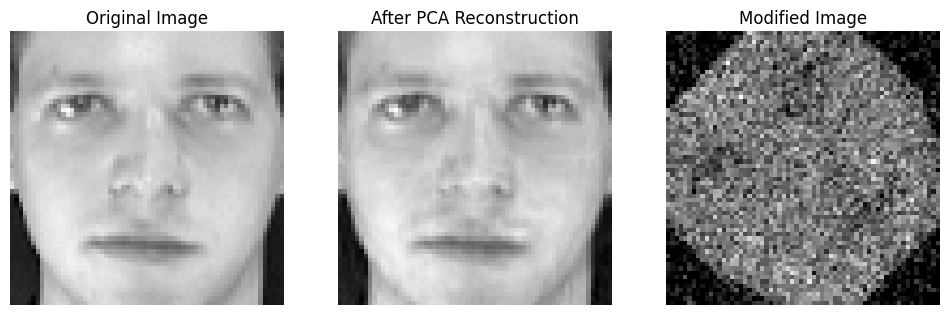

In [ ]:
# Display all images

original_image_index = 0  # Index of the image to display
original_image = faces.images[original_image_index]

# Reshape the PCA-reconstructed image back to its 2D form (64x64 pixels) for visualization
reconstructed_image = reconstructed_images[original_image_index].reshape(64, 64)

# Plotting Original Image
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plotting Image after PCA Reconstruction
axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title('After PCA Reconstruction')
axes[1].axis('off')

# Plotting Modified Image
axes[2].imshow(modified_image, cmap='gray')
axes[2].set_title('Modified Image')
axes[2].axis('off')

# Dispalys the 3 different versions of the first picture in the dataset
plt.show()

QUESTION 3

Write an extended abstract between one and half page to two pages to discuss the importance of one
of the following techniques.

1. Data Preprocessing
2. Feature Importance

To answer the above question, you can also do a tiny review of the literature to find out how your
chosen techniques are used across various application domains. Also, note that these techniques are
old and trendy and have laid the foundation for many other machine learning techniques.
The report must reflect on their capabilities and limitations in applying them to various applications. It must also include your reflections and critical comments, rather than simply reproducing what you found in the literature review.
Your report should conform to the APA 7th edition referencing/citation style for your report.

# Data Preprocessing
Big data preprocessing is essential when working with large datasets. It is an important step before data mining, and its purpose is to convert the data into a format that can be more easily and effectively processed during data mining.

As the use of big data has become more frequent, given the increased availability of data, data preprocessing has grown in importance. Garcia et al. (2016) discuss methods and prospects used to make data preprocessing as successful as possible. Techniques such as discretization and normalization, with methods like Binarizer, Bucketizer, discrete cosine transform, Normalizer, StandardScaler, and MinMaxScaler, are used to adjust and simplify data. Apart from reducing the data, techniques such as feature selection also play a crucial role. Instead of reducing the data, this method focuses on identifying a subset of relevant data features for use in model building, thereby reducing the dimensionality of the data and improving model performance. Imbalance learning is another challenge in preprocessing. Garcia et al. (2016) mention that imbalanced datasets, where some classes are underrepresented, can be addressed by using techniques such as Synthetic Minority Over-sampling Technique (SMOTE), which balances the class distribution by sampling the minority or majority class.

In specific sectors, such as the aerospace sector discussed by Famili et al. (1997), data preprocessing is widely used in analyzing operation and maintenance data from commercial aircraft. This includes addressing missing parameters, improper data types, and out-of-range data through elimination, data type correction, and range checking. This aligns with Garcia et al. (2016), who also mention normalization as a means of correcting data types for a specific variable. Although the article does not specify the techniques used, it is likely those discussed in Garcia's article (2016).

Looking at more recent trends, Mishra et al. (2020) discuss the new trends in data preprocessing, based on the ensemble of multiple preprocessing techniques. A technique used is the Sequential Preprocessing Through Orthogonalization (SPORT) approach, which is widely used in analytical chemistry, particularly in chemometrics applications. This approach is distinguished by its ability to systematically combine multiple preprocessing techniques, thereby harnessing the unique and complementary information each method brings to the table.

For example, the SPORT approach was utilized to predict dry matter in olive fruits, where multiple scatter correction techniques were applied sequentially. This fusion led to a notable reduction in prediction error and an increase in prediction accuracy, highlighting the synergistic effect of combining different preprocessing methods. SPORT stands out by enabling a detailed exploration of the unique information present in each preprocessing technique. Unlike traditional methods that might average or weight outputs without providing insights into the individual contributions, SPORT facilitates a deeper understanding of how combining different techniques improves the model. This is particularly advantageous in chemometrics, where the complexity and variability of data require sophisticated analytical strategies to achieve optimal results.

These methods present promising avenues for enhancing data quality and model performance, but it's crucial to thoroughly assess their strengths and limitations, particularly across diverse domains.

One significant consideration is how well these methods can scale to manage increasingly large datasets. While traditional preprocessing techniques may struggle with immense datasets, newer approaches such as SPORT aim to address this issue by incorporating multiple techniques in a scalable manner . However, it's important to evaluate the computational complexity and resource demands of these methods, particularly with extremely large datasets (Mishra et al. 2020).

Furthermore, the efficacy of preprocessing techniques can vary based on dataset characteristics and application requirements. While methods like SMOTE excel at handling class imbalance in classification tasks, they may not be suitable for all types of data or applications. It's crucial to carefully assess each technique's suitability for a given problem domain and dataset features Garcia et al. (2016).

Additionally, understanding the underlying principles and assumptions of each preprocessing technique is essential. Ensemble methods like SPORT offer the advantage of combining diverse techniques, but it's crucial to ensure their appropriate application and validity within the specific dataset context.

In summary, while preprocessing techniques are valuable for improving data quality and model performance, their application demands careful consideration of scalability, suitability for the problem domain, and underlying assumptions. By critically evaluating these factors, researchers and practitioners can make informed decisions when designing preprocessing pipelines for big data handling in real-world scenarios.




-------------




References

Famili, A., Shen, W.-M., Weber, R., & Simoudis, E. (1997). Data Preprocessing and Intelligent Data Analysis. Intelligent Data Analysis, 1(1), 3–23. https://doi.org/10.3233/IDA-1997-1102

García, S., Ramírez-Gallego, S., Luengo, J., et al. (2016). Big data preprocessing: methods and prospects. Big Data Analysis, 1(9). https://doi.org/10.1186/s41044-016-0014-0

Mishra, P., Biancolillo, A., Roger, J. M., Marini, F., & Rutledge, D. N. (2020). New data preprocessing trends based on ensemble of multiple preprocessing techniques. TrAC, Trends in Analytical Chemistry (Regular Ed.), 132, 116045-. https://doi.org/10.1016/j.trac.2020.116045
